# Markov Model

In this section we will elaborate an analysis using Markov chain theory. The theoretical knowledge come mostly from:

    Introduction to Modeling and Analysis of Stochastic Systems. by, V.G.Kulkami


In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from IPython.display import display, Math, Latex


In [2]:
#df = pd.read_excel('C:/Users/s157084/Google Drive/Projects Process Mining/Data/paths_taxonomy/sad_with_taxonomy.xlsx')
df = pd.read_csv('C:/Users/s157084/Google Drive/Projects Process Mining/Data/paths/sad_log_1Q_inclQ.csv', encoding = "ISO-8859-1")

C:\Users\s157084\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (19,42) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
def transition_matrix(df_id, df_event):
    """
    per session, lets count the sequence of events.
    P is the frequency matrix and PN is the stochastic matrix
    """
    
    events = pd.Series(df_event.unique())
    split = pd.Series(df_id.unique())
    P = pd.DataFrame(0, index= events, columns= events)
    T = pd.DataFrame(0, index= events, columns= events)
    #Calculate the trougthput time
    print('Computing the transition matrix')
    for i in split:
        df_event_temp = df_event[df_id == i]
        if len(df_event_temp) > 1:
            for j in range(1,len(df_event_temp)):
                P.loc[df_event_temp.iloc[j-1],df_event_temp.iloc[j]] += 1
                

    #Create the transition matrix
    print('Normalizing the transition matrix')
    cum_freq = np.sum(P, axis = 0)

    if len(cum_freq[cum_freq == 0]) > 0:
        print('P is NOT an stochastic matrix')
        print('the following events are deleted:')
        names_out = list(cum_freq[cum_freq == 0].index)
        print(names_out)
        P = P.drop(names_out, axis = 0)
        P = P.drop(names_out, axis = 1)
        print(P.shape)
        
    else: 
        print('P is an stochastic matrix')

    P = P/np.sum(P, axis = 0)
    print('done')
    
    
    return P
    
    
P = transition_matrix(df['sessionid'], df['event'])
    

Computing the transition matrix
Normalizing the transition matrix
P is NOT an stochastic matrix
the following values events are deleted:
['Visit page opzeggen-dienstverband', 'Visit page melding_sha2', 'Visit page onderwijs-overheid', 'Visit page werknemer']
(164, 164)
done


In [5]:
#Export the transition matrix to csv
P.to_csv('transition_matrix.csv')


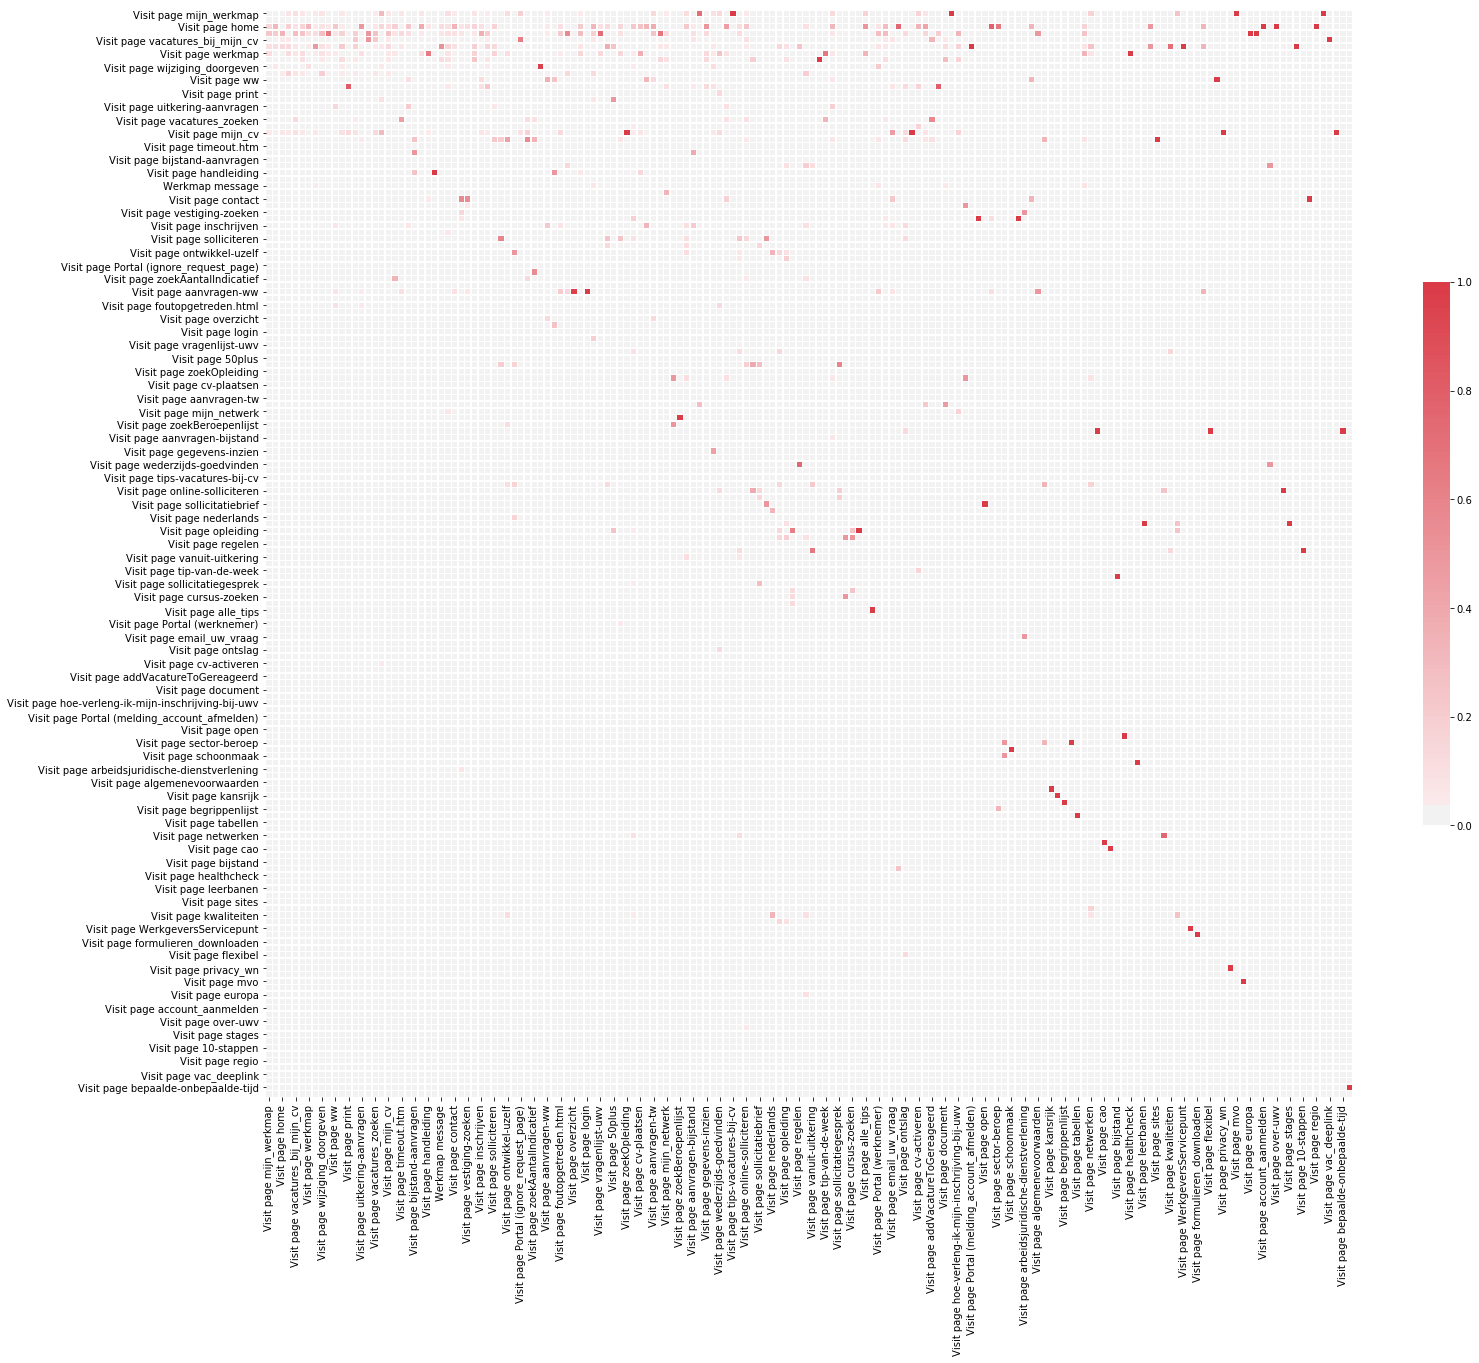

In [4]:
def print_matrix(X):
    mask = np.zeros_like(X, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = False
    f, ax = plt.subplots(figsize=(25, 20))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(X, mask=mask, cmap=cmap, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})
    mpl.pyplot.savefig('figures/Transition_matrix.png')
    plt.show()  
    
print_matrix(P)



# Dynamic Effect of the initial State on Users questions using Markonian Properties.

In this section we try to find patterns that eventually will lead to questions.


In [5]:

def create_stepwise_probabilities(P, n_steps, target):
    """
    P is the transition matrix, n_steps are the number of steps that must be considered to reach the target.
    """
    P_steps = pd.DataFrame()
    events = list(P)
    for step in range(n_steps):
        P_temp = pd.DataFrame(P[target])
        P_temp['step'] = step + 1
        P = pd.DataFrame(np.dot(P,P), index= events, columns= events)        
        P_steps = pd.concat([P_steps,P_temp],axis=0)

    P_steps['event'] = P_steps.index
    
    P_steps.columns = ['P', 'step', 'event']
    return P_steps.reset_index(drop=True), P
   
P_steps, PN = create_stepwise_probabilities(P.copy(), 4 ,'Question')

In [52]:
def Events_threshold(P_steps, threshold_range):
   """
   This function calculate the number of trigger events in diffirent thresholds intervals.
   """
        
        
    count_events = []
    
    for i in threshold_range:
        filter_ = pd.DataFrame()
        events = list(P_steps['event'].unique())
        #Calculate delta 
        for event in events:
            filter_temp = pd.DataFrame()
            P_steps_temp = P_steps[ P_steps['event'] == event] 
            filter_ = pd.concat([filter_, pd.DataFrame([event, np.max(P_steps_temp['P'].diff())])],axis = 1)
            
        filter_ = filter_.T
        filter_.columns = ['event', 'max_delta']

        filter_ = filter_[filter_['max_delta'] >= i]
        count_events.append(len(filter_))
        
    count_events = pd.concat([pd.Series(threshold_range), pd.Series(count_events)],axis = 1)
    count_events.columns = ['threshold_range', 'Numb_Trig_events']
    

    
    
    return count_events

temp_plot = Events_threshold(P_steps, np.arange(0.0, 0.05, 0.0001))    




## Aproximation funtion to calculate the number of trigger events:

The number of trigger events Y can be approximate by the equation:
$$Y = |-1.71| * e^{|-0.79| * X}$$

Where X is the a treshold value that is in the range $0<X<=0.05$. This equation is calculated based on the equation shown in the following graph

C:\Users\s157084\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


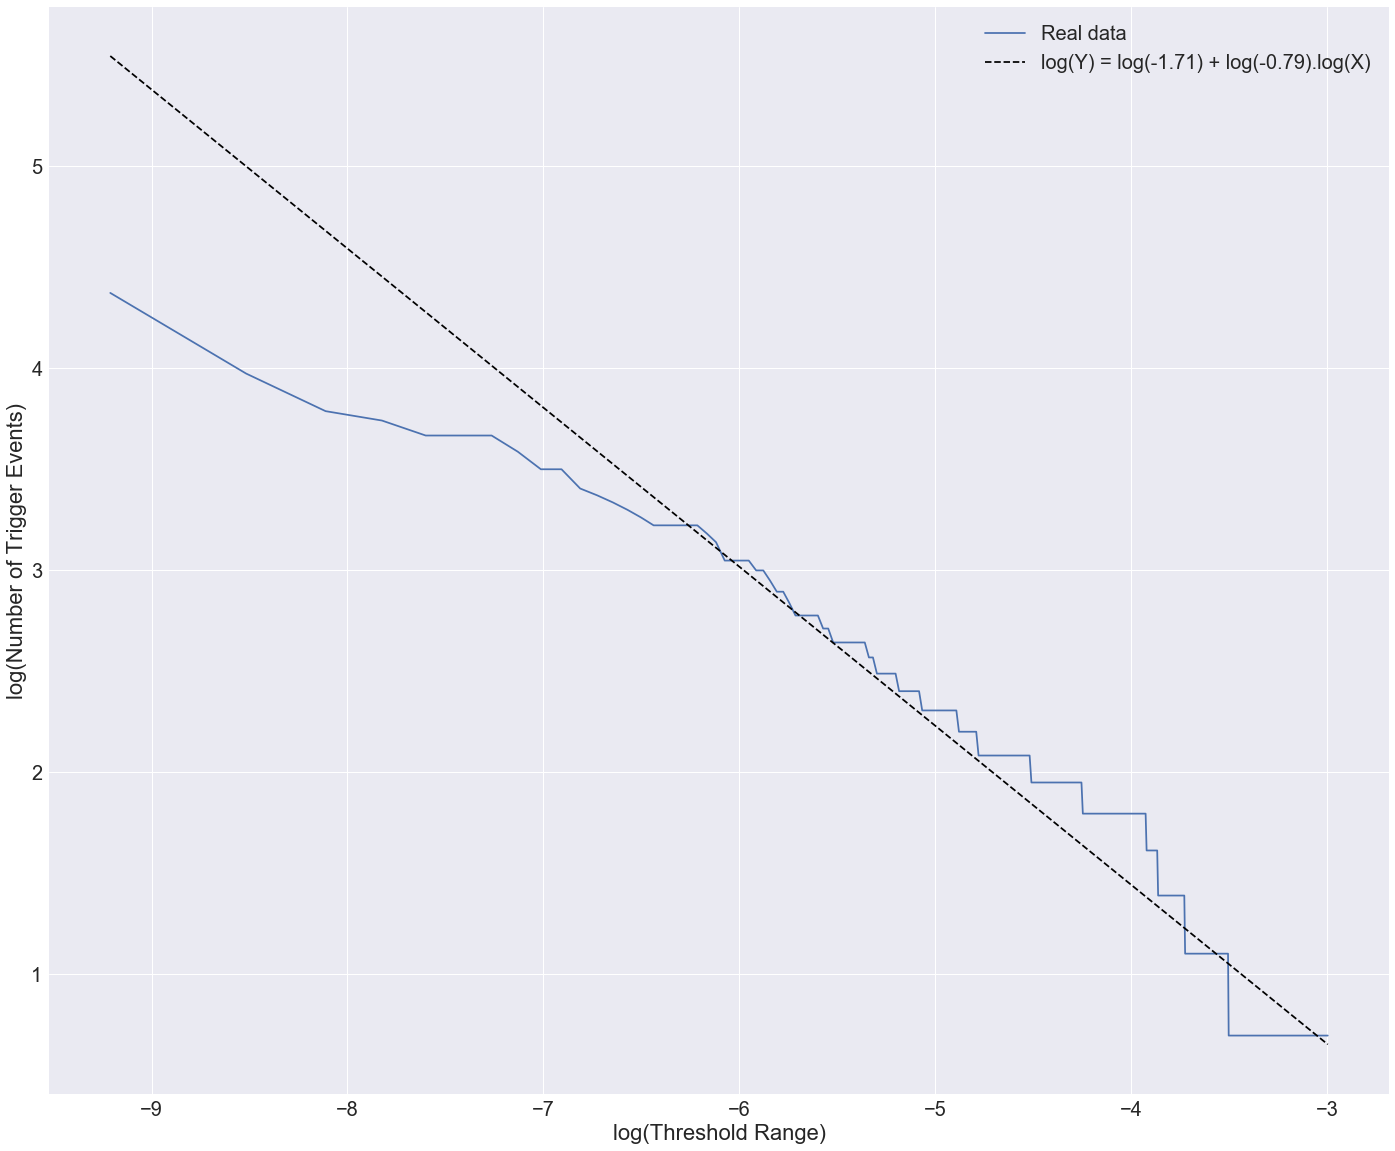

In [104]:
def only_plot(count_events):
    sns.set(font_scale=2)
    plt.figure(figsize=(24, 20))
    plt.plot(count_events['threshold_range'], count_events['Numb_Trig_events'], label = 'Real data')
    #Approximte the funtion in the log space
    b, m = np.polyfit(count_events['threshold_range'], count_events['Numb_Trig_events'], 1)
    plt.plot(count_events['threshold_range'], m + count_events['threshold_range'] * b,color='black', linestyle='--', label = 'log(Y) = ' + 'log({})'.format(str(round(m,2))) + ' + ' + 'log({})'.format(str(round(b,2))) + '.log(X)')
    plt.legend(loc='upper right')
    plt.xlabel('log(Threshold Range)')
    plt.ylabel('log(Number of Trigger Events)')

    #plt.savefig('roc_and_threshold.png')
    plt.show()
    plt.close()

only_plot(np.log(temp_plot)[1::])


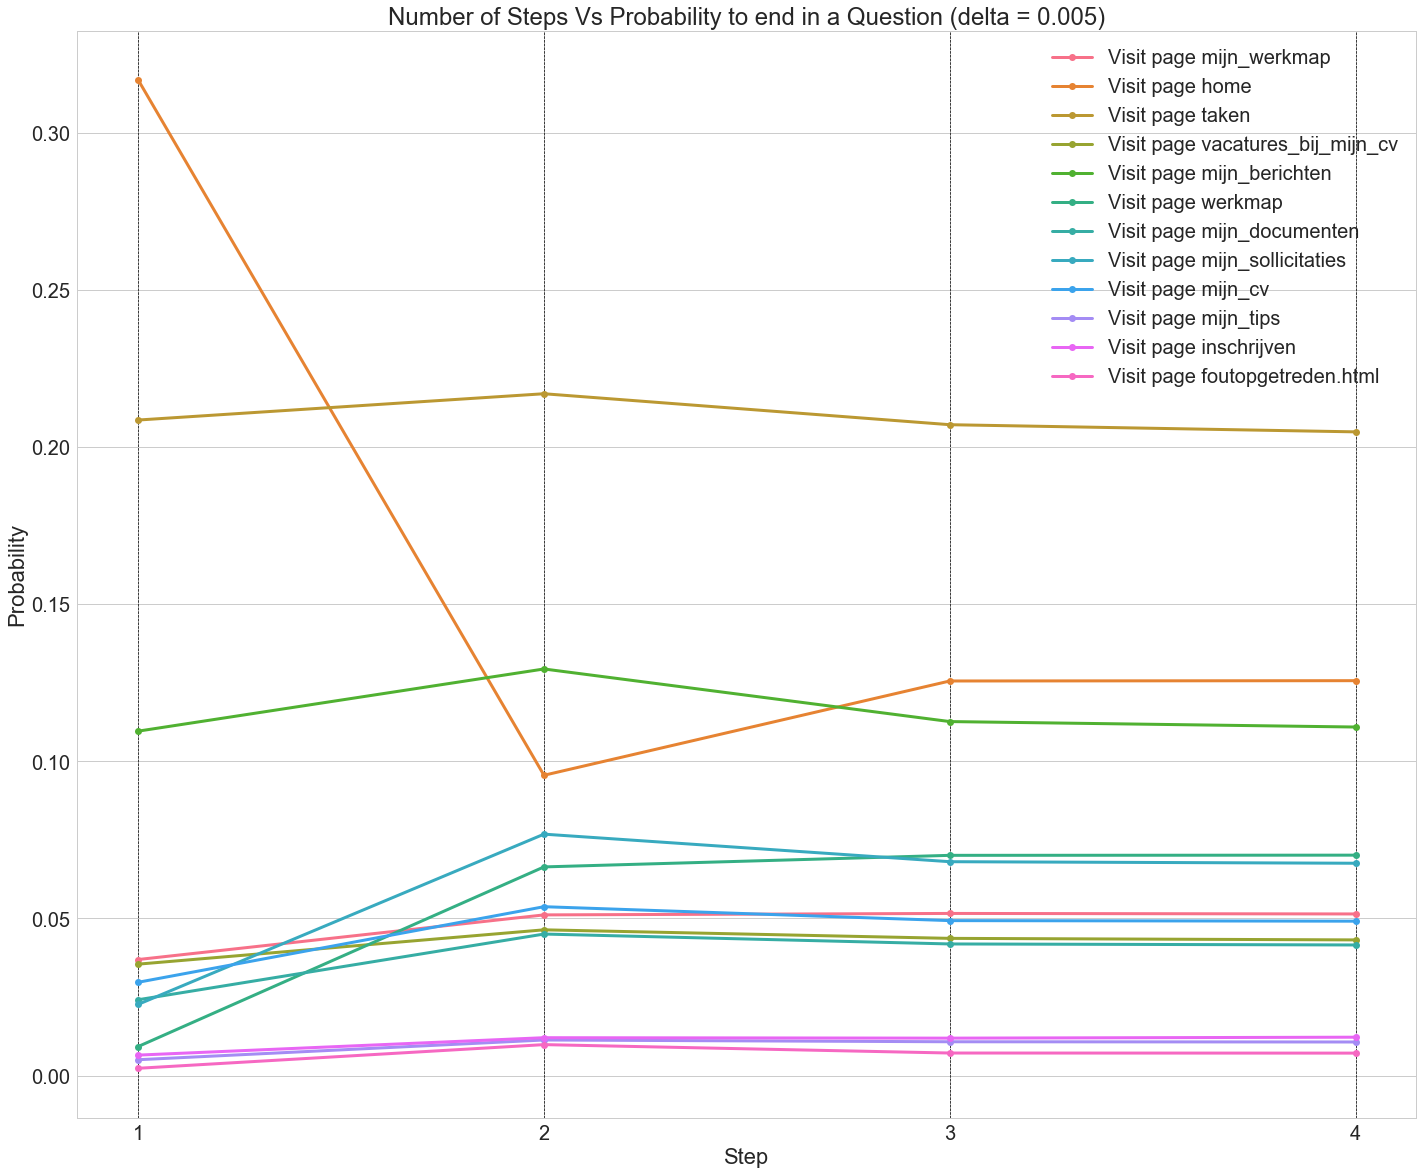

In [50]:
def plot_stepwise_prob(P_steps, threshold, delta = False):
    """
    Plot how the probabilities of different steps change in time. Only take into account events that have a max probability
    bigger than the threshold
    """
    
    if delta == False:    
        filter_ = P_steps.groupby(['event'])['P'].max()

    else:
        filter_ = pd.DataFrame()
        events = list(P_steps['event'].unique())
        #Calculate delta 
        for event in events:
            filter_temp = pd.DataFrame()
            P_steps_temp = P_steps[P_steps['event'] == event] 
            filter_ = pd.concat([filter_, pd.DataFrame([event, np.max(P_steps_temp['P'].diff())])],axis = 1)
            

    filter_ = filter_.T
    filter_.columns = ['event', 'max_delta']
    filter_ = filter_[filter_['max_delta'] >= threshold]
    names_in = list(filter_['event'])
    P_steps = P_steps[P_steps['event'].isin(names_in)]   

    
    #Create the graph
    sns.set(font_scale=2)
    sns.set_palette(sns.color_palette("husl", len(P_steps['event'].unique())))
    
    sns.set_style("whitegrid")
    f, ax = plt.subplots(figsize=(24, 20))
    ax.set_title('Number of Steps Vs Probability to end in a Question (delta = {})'.format(str(threshold)))

    for st in list(P_steps['step'].unique()):
        ax.axvline(x=st,color='black', linestyle='--', linewidth=0.7)
    
    
    for event in list(P_steps['event'].unique()):
        temp_P = P_steps[P_steps['event'] == event]
        ax.plot(temp_P['step'], temp_P['P'], 'o-', linewidth = 3, label = event )

    ax.legend(loc='upper right')
    ax.set(xlabel='Step', ylabel='Probability')    
    plt.xticks(list(P_steps['step'].unique()))
    
    mpl.pyplot.savefig('figures/trigger_events.png')
    plt.show()
    
    return P_steps
    
#P_temp = plot_stepwise_prob(P_steps[P_steps['event'] == 'Visit page readdetails'], 0, True)
P_temp = plot_stepwise_prob(P_steps.copy(), 0.005, True)


In [ ]:
#Transition Matrix of the events that may trigger questions
sig_events = list(P_temp['event'].unique())
sig_events.append('Question')
print_matrix(P.loc[sig_events,sig_events])